# Baseline and model pipelines

In [0]:
blob_container = "blobcontainer" # The name of your container created in https://portal.azure.com
storage_account = "w261section05group03" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261section05group04" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "houseofthedragon" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.linalg import DenseVector, SparseVector, Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler

from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

## Read Dataset

In [0]:
train_set = spark.read.parquet(f"{blob_url}/train_set_1")

In [0]:
display(train_set)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ORIGIN_icao ORIGIN_iata ORIGIN_airport_name ORIGIN_airport_city ORIGIN_airport_subd ORIGIN_airport_country ORIGIN_elevation ORIGIN_airport_lat ORIGIN_airport_lon ORIGIN_airport_tz flight_id ORIGIN_FLIGHT_TIMESTAMP HOUR_WEATHER_TIMESTAMP WEATHER_TIMESTAMP TWO_HOUR_WEATHER_TIMESTAMP THREE_HOUR_WEATHER_TIMESTAMP ORIGIN_STATION_ID ORIGIN_STATION_NAME ORIGIN_STATION_ELEVATION ORIGIN_STATION_LATITUDE ORIGIN_STATION_LONGITUDE ORIGIN_WEATHER_DATE ORIGIN_WEATHER_REPORT_TYPE ORIGIN_WEATHER_SOURCE ORIGIN_HourlyPrecipitation ORIGIN_HourlyPresentWeatherType ORIGIN_STATION_TIMESTAMP HOUR_TIMESTAMP ORIGIN_HourlyDewPointTemperature ORIGIN_HourlyDryBulbTemperature ORIGIN_HourlyWetBulbTemperature ORIGIN_HourlyStationPressure ORIGIN_HourlyWindDirection ORIGIN_HourlyWindSpeed ORIGIN_HourlyVisibility ORIGIN_AU_code ORIGIN_AW_code ORIGIN_MW_code ORIGIN_AU_TS ORIGIN_AU_ICE ORIGIN_AU_SNOW ORIGIN_AU_FOG ORIGIN_AW_TS ORIGIN_AW_ICE ORIGIN_AW_SNOW ORIGIN_AW_FOG ORIGIN_MW_TS ORIGIN_MW_ICE ORIGIN_MW_SNOW ORIGIN_MW_FOG ORIGIN_TS ORIGIN_ICE ORIGIN_SNOW ORIGIN_FOG DEST_icao DEST_iata DEST_airport_name DEST_airport_city DEST_airport_subd DEST_airport_country DEST_elevation DEST_airport_lat DEST_airport_lon DEST_airport_tz DEST_STATION_ID DEST_STATION_NAME DEST_STATION_ELEVATION DEST_STATION_LATITUDE DEST_STATION_LONGITUDE DEST_WEATHER_DATE DEST_WEATHER_REPORT_TYPE DEST_WEATHER_SOURCE DEST_HourlyPrecipitation DEST_HourlyPresentWeatherType DEST_STATION_TIMESTAMP DEST_HourlyDewPointTemperature DEST_HourlyDryBulbTemperature DEST_HourlyWetBulbTemperature DEST_HourlyStationPressure DEST_HourlyWindDirection DEST_HourlyWindSpeed DEST_HourlyVisibility DEST_AU_code DEST_AW_code DEST_MW_code DEST_AU_TS DEST_AU_ICE DEST_AU_SNOW DEST_AU_FOG DEST_AW_TS DEST_AW_ICE DEST_AW_SNOW DEST_AW_FOG DEST_MW_TS DEST_MW_ICE DEST_MW_SNOW DEST_MW_FOG DEST_TS DEST_ICE DEST_SNOW DEST_FOG ARRIVAL_FLIGHT_TIMESTAMP PREV_DEP_DELAY PREV_DEPARTURE_TIMESTAMP PREV_ARR_DELAY PREV_ARRIVAL_TIMESTAMP 1 1 1 4 2015-01-01 US 20355 N176UW 11298 DFW TX 11057 CLT NC 1210 1205 -5.0 0.0 0.0 -1 1200-1259 1529 1531 2.0 2.0 0.0 0 1500-1559 0.0 0.0 936.0 4 0.0 0.0 0.0 0.0 0.0 2015 KDFW DFW Dallas Fort Worth International Airport Dallas-Fort Worth Texas US 607.0 32.8968009949 -97.0380020142 America/Chicago 111670164162 2015-01-01T18:10:00.000+0000 2015010116 2015-01-01T16:10:00.000+0000 2015010115 2015010114 72259003927 DAL FTW WSCMO AIRPORT, TX US 170.7 32.8978 -97.0189 2015-01-01T10:02:00 FM-16 7 0.01 -FZ:8 RA:02 BR:1 |FZRA | 2015-01-01T16:02:00.000+0000 2015010116 30.0 32.0 31.0 29.68 70.0 5.0 2.0 -FZ:8 RA:02 BR:1 FZRA 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 KCLT CLT Charlotte Douglas International Airport Charlotte North Carolina US 748.0 35.2140007019 -80.9430999756 America/New_York 72314013881 CHARLOTTE DOUGLAS AIRPORT, NC US 221.9 35.2236 -80.9552 2015-01-01T10:52:00 FM-15 7 0.0 null 2015-01-01T15:52:00.000+0000 34.0 43.0 39.0 29.5 240.0 3.0 10.0 null null null 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2015-01-01T20:29:00.000+0000 0.0 null 0.0 null 1 1 1 4 2015-01-01 US 20355 N176UW 11057 CLT NC 10721 BOS MA 1610 1651 41.0 41.0 1.0 2 1600-1659 1813 1842 29.0 29.0 1.0 1 1800-1859 0.0 0.0 728.0 3 20.0 0.0 0.0 0.0 9.0 2015 KCLT CLT Charlotte Douglas International Airport Charlotte North Carolina US 748.0 35.2140007019 -80.9430999756 America/New_York 188979907419 2015-01-01T21:10:00.000+0000 2015010119 2015-01-01T19:10:00.000+0000 2015010118 2015010117 72314013881 CHARLOTTE DOUGLAS AIRPORT, NC US 221.9 35.2236 -80.9552 2015-01-01T13:52:00 FM-15 7 0.0 null 2015-01-01T18:52:0

In [0]:
train_set.columns

Out[11]: ['QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
 'TAIL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN',
 'ORIGIN_STATE_ABR',
 'DEST_AIRPORT_ID',
 'DEST',
 'DEST_STATE_ABR',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'ARR_DEL15',
 'ARR_DELAY_GROUP',
 'ARR_TIME_BLK',
 'CANCELLED',
 'DIVERTED',
 'DISTANCE',
 'DISTANCE_GROUP',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'YEAR',
 'ORIGIN_icao',
 'ORIGIN_iata',
 'ORIGIN_airport_name',
 'ORIGIN_airport_city',
 'ORIGIN_airport_subd',
 'ORIGIN_airport_country',
 'ORIGIN_elevation',
 'ORIGIN_airport_lat',
 'ORIGIN_airport_lon',
 'ORIGIN_airport_tz',
 'flight_id',
 'ORIGIN_FLIGHT_TIMESTAMP',
 'HOUR_WEATHER_TIMESTAMP',
 'WEATHER_TIMESTAMP',
 'TWO_HOUR_WEATHER_TIMESTAMP',
 'THREE_HOUR_WEATHER_TIMESTAMP',

## EDA

In [0]:
train_set = spark.read.parquet(f"{blob_url}/train_set_1")
test_set =spark.read.parquet(f"{blob_url}/dev_set_1")

In [0]:
print(f'Dimensions of Train Set are: {train_set.count()}, {len(train_set.columns)}')
print(f'Dimensions of Test Set are: {test_set.count()}, {len(test_set.columns)}')

Dimensions of Train Set are: 5655169, 154
Dimensions of Test Set are: 838352, 154


In [0]:
train_set.select("YEAR").distinct().show()

+----+
|YEAR|
+----+
|2015|
+----+



In [0]:
test_set.select("YEAR").distinct().show()

+----+
|YEAR|
+----+
|2015|
|2016|
+----+



In [0]:
display(train_set)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ORIGIN_icao ORIGIN_iata ORIGIN_airport_name ORIGIN_airport_city ORIGIN_airport_subd ORIGIN_airport_country ORIGIN_elevation ORIGIN_airport_lat ORIGIN_airport_lon ORIGIN_airport_tz flight_id ORIGIN_FLIGHT_TIMESTAMP HOUR_WEATHER_TIMESTAMP WEATHER_TIMESTAMP TWO_HOUR_WEATHER_TIMESTAMP THREE_HOUR_WEATHER_TIMESTAMP ORIGIN_STATION_ID ORIGIN_STATION_NAME ORIGIN_STATION_ELEVATION ORIGIN_STATION_LATITUDE ORIGIN_STATION_LONGITUDE ORIGIN_WEATHER_DATE ORIGIN_WEATHER_REPORT_TYPE ORIGIN_WEATHER_SOURCE ORIGIN_HourlyPrecipitation ORIGIN_HourlyPresentWeatherType ORIGIN_STATION_TIMESTAMP HOUR_TIMESTAMP ORIGIN_HourlyDewPointTemperature ORIGIN_HourlyDryBulbTemperature ORIGIN_HourlyWetBulbTemperature ORIGIN_HourlyStationPressure ORIGIN_HourlyWindDirection ORIGIN_HourlyWindSpeed ORIGIN_HourlyVisibility ORIGIN_AU_code ORIGIN_AW_code ORIGIN_MW_code ORIGIN_AU_TS ORIGIN_AU_ICE ORIGIN_AU_SNOW ORIGIN_AU_FOG ORIGIN_AW_TS ORIGIN_AW_ICE ORIGIN_AW_SNOW ORIGIN_AW_FOG ORIGIN_MW_TS ORIGIN_MW_ICE ORIGIN_MW_SNOW ORIGIN_MW_FOG ORIGIN_TS ORIGIN_ICE ORIGIN_SNOW ORIGIN_FOG DEST_icao DEST_iata DEST_airport_name DEST_airport_city DEST_airport_subd DEST_airport_country DEST_elevation DEST_airport_lat DEST_airport_lon DEST_airport_tz DEST_STATION_ID DEST_STATION_NAME DEST_STATION_ELEVATION DEST_STATION_LATITUDE DEST_STATION_LONGITUDE DEST_WEATHER_DATE DEST_WEATHER_REPORT_TYPE DEST_WEATHER_SOURCE DEST_HourlyPrecipitation DEST_HourlyPresentWeatherType DEST_STATION_TIMESTAMP DEST_HourlyDewPointTemperature DEST_HourlyDryBulbTemperature DEST_HourlyWetBulbTemperature DEST_HourlyStationPressure DEST_HourlyWindDirection DEST_HourlyWindSpeed DEST_HourlyVisibility DEST_AU_code DEST_AW_code DEST_MW_code DEST_AU_TS DEST_AU_ICE DEST_AU_SNOW DEST_AU_FOG DEST_AW_TS DEST_AW_ICE DEST_AW_SNOW DEST_AW_FOG DEST_MW_TS DEST_MW_ICE DEST_MW_SNOW DEST_MW_FOG DEST_TS DEST_ICE DEST_SNOW DEST_FOG ARRIVAL_FLIGHT_TIMESTAMP PREV_DEP_DELAY PREV_DEPARTURE_TIMESTAMP PREV_ARR_DELAY PREV_ARRIVAL_TIMESTAMP 1 1 1 4 2015-01-01 US 20355 N176UW 11298 DFW TX 11057 CLT NC 1210 1205 -5.0 0.0 0.0 -1 1200-1259 1529 1531 2.0 2.0 0.0 0 1500-1559 0.0 0.0 936.0 4 0.0 0.0 0.0 0.0 0.0 2015 KDFW DFW Dallas Fort Worth International Airport Dallas-Fort Worth Texas US 607.0 32.8968009949 -97.0380020142 America/Chicago 111670164162 2015-01-01T18:10:00.000+0000 2015010116 2015-01-01T16:10:00.000+0000 2015010115 2015010114 72259003927 DAL FTW WSCMO AIRPORT, TX US 170.7 32.8978 -97.0189 2015-01-01T10:02:00 FM-16 7 0.01 -FZ:8 RA:02 BR:1 |FZRA | 2015-01-01T16:02:00.000+0000 2015010116 30.0 32.0 31.0 29.68 70.0 5.0 2.0 -FZ:8 RA:02 BR:1 FZRA 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 KCLT CLT Charlotte Douglas International Airport Charlotte North Carolina US 748.0 35.2140007019 -80.9430999756 America/New_York 72314013881 CHARLOTTE DOUGLAS AIRPORT, NC US 221.9 35.2236 -80.9552 2015-01-01T10:52:00 FM-15 7 0.0 null 2015-01-01T15:52:00.000+0000 34.0 43.0 39.0 29.5 240.0 3.0 10.0 null null null 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2015-01-01T20:29:00.000+0000 0 null 0.0 null 1 1 1 4 2015-01-01 US 20355 N176UW 11057 CLT NC 10721 BOS MA 1610 1651 41.0 41.0 1.0 2 1600-1659 1813 1842 29.0 29.0 1.0 1 1800-1859 0.0 0.0 728.0 3 20.0 0.0 0.0 0.0 9.0 2015 KCLT CLT Charlotte Douglas International Airport Charlotte North Carolina US 748.0 35.2140007019 -80.9430999756 America/New_York 188979907419 2015-01-01T21:10:00.000+0000 2015010119 2015-01-01T19:10:00.000+0000 2015010118 2015010117 72314013881 CHARLOTTE DOUGLAS AIRPORT, NC US 221.9 35.2236 -80.9552 2015-01-01T13:52:00 FM-15 7 0.0 null 2015-01-01T18:52:00.

In [0]:
cols_to_keep = ['DEP_DEL15','DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'PER_DELAY_15_ORIGIN_LAST_3']

# cols_to_drop = ['DIV4_AIRPORT', 'DIV4_TOTAL_GTIME', 'DIV3_TOTAL_GTIME',
#        'DIV3_WHEELS_ON', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_AIRPORT_ID',
#        'DIV3_AIRPORT', 'DIV3_TAIL_NUM', 'DIV3_WHEELS_OFF',
#        'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON',
#        'DIV3_LONGEST_GTIME', 'DIV4_LONGEST_GTIME', 'DIV5_TAIL_NUM',
#        'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_WHEELS_OFF',
#        'DIV5_LONGEST_GTIME', 'DIV5_TOTAL_GTIME', 'DIV5_WHEELS_ON',
#        'DIV5_AIRPORT_SEQ_ID', 'DIV5_AIRPORT_ID', 'DIV4_WHEELS_OFF',
#        'DIV2_TAIL_NUM', 'DIV2_WHEELS_OFF', 'DIV2_WHEELS_ON',
#        'DIV2_AIRPORT', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME',
#        'DIV2_AIRPORT_SEQ_ID', 'DIV2_AIRPORT_ID', 'DIV_ARR_DELAY',
#        'DIV_ACTUAL_ELAPSED_TIME', 'DIV1_TAIL_NUM', 'DIV1_WHEELS_OFF',
#        'DIV_DISTANCE', 'DIV_REACHED_DEST', 'DIV1_AIRPORT_SEQ_ID',
#        'DIV1_TOTAL_GTIME', 'DIV1_WHEELS_ON', 'DIV1_AIRPORT_ID',
#        'DIV1_AIRPORT', 'DIV1_LONGEST_GTIME', 'LONGEST_ADD_GTIME',
#        'TOTAL_ADD_GTIME', 'FIRST_DEP_TIME'] 

# cols = train_set_df.columns
# cols_to_keep = []
# remove_cols = set(cols_to_drop)
# for col in cols:
#   if not col in remove_cols:
#     cols_to_keep.append(col)

train_set_df = train_set.select(cols_to_keep).sample(False, .01, seed = 7).toPandas()

In [0]:
train_set_df.head(10)

DEP_DEL15 
 DISTANCE 
 PREV_DEP_DELAY 
 CRS_DEP_TIME 
 CRS_ARR_TIME 
 PER_DELAY_15_ORIGIN_LAST_3 
 
 
 
 
 0 
 0.0 
 689.0 
 0.0 
 810 
 932 
 1.000000 
 
 
 1 
 0.0 
 669.0 
 0.0 
 1050 
 1155 
 0.130435 
 
 
 2 
 1.0 
 1541.0 
 0.0 
 1050 
 1308 
 0.130435 
 
 
 3 
 0.0 
 946.0 
 5.0 
 1635 
 1905 
 0.109489 
 
 
 4 
 0.0 
 813.0 
 0.0 
 1850 
 2030 
 0.110497 
 
 
 5 
 0.0 
 631.0 
 0.0 
 1950 
 2149 
 0.102273 
 
 
 6 
 0.0 
 794.0 
 0.0 
 2042 
 2254 
 0.124031 
 
 
 7 
 0.0 
 581.0 
 0.0 
 700 
 850 
 0.000000 
 
 
 8 
 0.0 
 399.0 
 0.0 
 939 
 1100 
 0.033333 
 
 
 9 
 0.0 
 192.0 
 1.0 
 1218 
 1316 
 0.156098

In [0]:
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("DataFrame has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [0]:
info_missing_table(train_set_df)

DataFrame has 5 columns.
There are 0 columns that have missing values.


Missing Values 
 % of Total Values

In [0]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# interpret

alpha = 0.05

for i in train_set_df:
    stat, p = shapiro(train_set_df[[i]])
    #print(sample_df[[i]])
    if p > alpha:
        print(f'Variable {i} looks Gaussian (fail to reject H0) at {p:0.5}')
    else:
        print(f'Variable {i} does NOT look Gaussian (reject H0)  at {p:.5}')

Variable DEP_DEL15 does NOT look Gaussian (reject H0)  at 0.0
Variable DISTANCE does NOT look Gaussian (reject H0)  at 0.0
Variable PREV_DEP_DELAY does NOT look Gaussian (reject H0)  at 0.0
Variable CRS_DEP_TIME does NOT look Gaussian (reject H0)  at 0.0
Variable CRS_ARR_TIME does NOT look Gaussian (reject H0)  at 0.0
/databricks/python/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Define Features to Keep

In [0]:
features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME']

# Log Model

## Train Log Model

In [0]:
from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

# Load the train set
train_set = spark.read.parquet(f"{blob_url}/train_set")

# Make sure the target variable is not null
train_set = train_set.where("DEP_DEL15 is not NULL")

train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Use Vetor Assembler to create the features column
features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'PER_DELAY_15_ORIGIN_LAST_3']
vectorAssembler = VectorAssembler(inputCols = features_to_keep, outputCol = 'features')
train_df = vectorAssembler.transform(train_set)
train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Standardize Features using train set
scaler = MinMaxScaler(inputCol="features", outputCol="featured_scaled")
scaler_model = scaler.fit( train_df.select("features") )
train_df = scaler_model.transform(train_df)

# Train the logistic regression
lr = LogisticRegression()
lr_Model = lr.fit(train_df)

# Load the dev set
test_set = spark.read.parquet(f"{blob_url}/test_set")
test_set = test_set.where("DEP_DEL15 is not NULL")

test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Create the features column
test_df = vectorAssembler.transform(test_set)
test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Standardize Features using train set
test_df = scaler_model.transform(test_df)

# Use the model on the test set
testSet = lr_Model.transform(test_df)

In [0]:
print("Model 1 was fit using parameters: ")
print(lr_Model.extractParamMap())

Model 1 was fit using parameters: 
{Param(parent='LogisticRegression_425b92c93228', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_425b92c93228', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_425b92c93228', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_425b92c93228', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_425b92c93228', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_425b92c93228', name='labelCol', doc='label column name.'): 'label', Param(parent='LogisticRegression_425b92c93228', name='maxBlockSizeInMB', do

## Evaluate Log Model

In [0]:
# Show some results
lm_baseline = testSet.select("label", "prediction").rdd.map(lambda x: (x[1], x[0]))

evaluator = BinaryClassificationEvaluator()

# calculate AUC
auc = evaluator.evaluate(testSet, {evaluator.metricName: 'areaUnderROC'})
print('AUC: %0.3f' % auc)

metrics = MulticlassMetrics(lm_baseline)
precision = metrics.precision(label=1)
print(f'Precision: {precision:.3f}')
recall = metrics.recall(label=1)
print(f'Recall: {recall:.3f}')
f2Score = metrics.fMeasure(1.0, 2.0)
print(f'F2Score: {f2Score:.3f}')

AUC: 0.703
/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Precision: 0.651
Recall: 0.091
F2Score: 0.110


In [0]:
# cm = testSet.groupBy('label','prediction').count().sort('label','prediction')
# print("Confusion matrix")
# cm.show()

Confusion matrix, without normalization
[[  91592  912109]
 [  49167 4760226]]


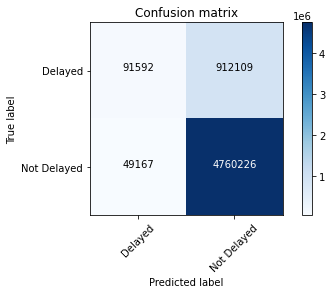

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

class_names=['Delayed','Not Delayed']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_true = testSet.select("label")
y_true = y_true.toPandas()
y_true['label'] = y_true['label'].replace([0],'Not Delayed')
y_true['label'] = y_true['label'].replace([1],'Delayed')

y_pred = testSet.select("prediction")
y_pred = y_pred.toPandas()
y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

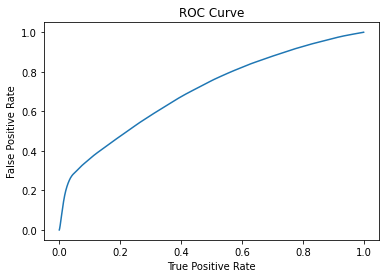

Training set areaUnderROC: 0.7025540055554211


In [0]:
trainingSummary = lr_Model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Interpretation

In [0]:
import shap



## Log Model with Grid Search

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
params = ParamGridBuilder()
params = params.addGrid(lr.regParam, [.01, .1, 1, 10]) \
               .addGrid(lr.elasticNetParam, [0, .5, 1])
params = params.build()

# Decision Tree

In [0]:
from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

# Load the train set
train_set = spark.read.parquet(f"{blob_url}/train_set_1")

# Make sure the target variable is not null
train_set = train_set.where("DEP_DEL15 is not NULL")

train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Use Vetor Assembler to create the features column

features_to_keep = ['DISTANCE', 'PREV_DEP_15', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
vectorAssembler = VectorAssembler(inputCols =  features_to_keep, outputCol = 'features')
train_df = vectorAssembler.transform(train_set)
train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Load the dev set
test_set = spark.read.parquet(f"{blob_url}/dev_set_1")
test_set = test_set.where("DEP_DEL15 is not NULL")

test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Create the features column
test_df = vectorAssembler.transform(test_set)
test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

## Train DT Model

In [0]:
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features', impurity='gini', maxDepth=5, maxBins=32) # 30 trees, 30 max depth is way too much

dt_Model = dt.fit(train_df)

## Evaluate DT Model

In [0]:
testSet = dt_Model.transform(test_df)

In [0]:
dt_predictions = testSet.select("label", "prediction").rdd.map(lambda x: (x[1], x[0]))

evaluator = BinaryClassificationEvaluator()

# calculate AUC
# auc = evaluator.evaluate(rm_predictions, {evaluator.metricName: 'areaUnderROC'})
# print('AUC: %0.3f' % auc)

metrics = MulticlassMetrics(dt_predictions)
precision = metrics.precision(label=1)
print(f'Precision: {precision:.3f}')
recall = metrics.recall(label=1)
print(f'Recall: {recall:.3f}')
f2Score = metrics.fMeasure(1.0, 2.0)
print(f'F2Score: {f2Score:.3f}')

Precision: 0.563
Recall: 0.320
F2Score: 0.350


In [0]:
y_true = testSet.select("label")
y_true = y_true.toPandas()
y_true['label'] = y_true['label'].replace([0],'Not Delayed')
y_true['label'] = y_true['label'].replace([1],'Delayed')

y_pred = testSet.select("prediction")
y_pred = y_pred.toPandas()
y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2647101326227519> in <cell line: 11>()
      9 y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')
     10 
---> 11 cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
     12 
     13 plt.figure()

NameError: name 'confusion_matrix' is not defined

In [0]:
# trainingSummary = dt_Model.summary
# roc = trainingSummary.roc.toPandas()
# plt.plot(roc['FPR'],roc['TPR'])
# plt.ylabel('False Positive Rate')
# plt.xlabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()
# print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2647101326227451> in <cell line: 1>()
----> 1 trainingSummary = dt_Model.summary
      2 roc = trainingSummary.roc.toPandas()
      3 plt.plot(roc['FPR'],roc['TPR'])
      4 plt.ylabel('False Positive Rate')
      5 plt.xlabel('True Positive Rate')

AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'summary'

# Random Forest

## Train RF Model

In [0]:
from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

# Load the train set
train_set = spark.read.parquet(f"{blob_url}/train_set_1")

# Make sure the target variable is not null
train_set = train_set.where("DEP_DEL15 is not NULL")

train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Use Vetor Assembler to create the features column

features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'PER_DELAY_15_ORIGIN_LAST_3']
vectorAssembler = VectorAssembler(inputCols =  features_to_keep, outputCol = 'features')
train_df = vectorAssembler.transform(train_set)
train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Load the dev set
test_set = spark.read.parquet(f"{blob_url}/dev_set_1")
test_set = test_set.where("DEP_DEL15 is not NULL")

test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Create the features column
test_df = vectorAssembler.transform(test_set)
test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

In [0]:
# NOT BEING RUN AT THE MOMENT
# source: https://shihaojran.com/distributed-machine-learning-using-pyspark/

from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

carrier_indexer = StringIndexer(inputCol='OP_UNIQUE_CARRIER', outputCol='arr_idx').setHandleInvalid("keep")
origin_indexer = StringIndexer(inputCol='ORIGIN', outputCol='org_idx').setHandleInvalid("keep")
dest_indexer = StringIndexer(inputCol='DEST', outputCol='des_idx').setHandleInvalid("keep")

# stay away from OneHotEncoderEstimator

onehot = OneHotEncoderEstimator(inputCols=[carrier_indexer.getOutputCol(), origin_indexer.getOutputCol(),
                                           dest_indexer.getOutputCol()],
                                outputCols=['carrier_dummy', 'origin_dummy', 'dest_dummy'])

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                            numTrees=10, maxDepth=7) # 30 trees, 30 max depth is way too much

rf_Model = rf.fit(train_df)

pipeline = Pipeline(stages=[
#     arr_indexer, org_indexer, des_indexer, onehot, 
    assembler, rf])

In [0]:
testSet = rf_Model.transform(test_df)

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

param = ParamGridBuilder().build()

# cv = CrossValidator(estimator=pipeline,
#                     estimatorParamMaps=params,
#                     evaluator=evaluator,
#                     numFolds=5)

cv = cv.fit(train_set)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2647101326227153> in <cell line: 3>()
      2 param = ParamGridBuilder().build()
      3 cv = CrossValidator(estimator=pipeline,
----> 4                     estimatorParamMaps=params,
      5                     evaluator=evaluator,
      6                     numFolds=5)

NameError: name 'params' is not defined

## Evaluate RF Model

In [0]:
rm_predictions = testSet.select("label", "prediction").rdd.map(lambda x: (x[1], x[0]))

evaluator = BinaryClassificationEvaluator()

# calculate AUC
# auc = evaluator.evaluate(rm_predictions, {evaluator.metricName: 'areaUnderROC'})
# print('AUC: %0.3f' % auc)

metrics = MulticlassMetrics(rm_predictions)
precision = metrics.precision(label=1)
print(f'Precision: {precision:.3f}')
recall = metrics.recall(label=1)
print(f'Recall: {recall:.3f}')
f2Score = metrics.fMeasure(1.0, 2.0)
print(f'F2Score: {f2Score:.3f}')

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Precision: 0.674
Recall: 0.271
F2Score: 0.308


In [0]:
rm_predictions.show()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2647101326227399> in <cell line: 1>()
----> 1 rm_predictions.show()

AttributeError: 'PipelinedRDD' object has no attribute 'show'

In [0]:
cm = testSet.groupBy('label','prediction').count().sort('label','prediction')
print("Confusion matrix")
cm.show()

Confusion matrix
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|691215|
|  0.0|       1.0| 17063|
|  1.0|       0.0| 94803|
|  1.0|       1.0| 35271|
+-----+----------+------+



Confusion matrix, without normalization
[[ 35271  94803]
 [ 17063 691215]]


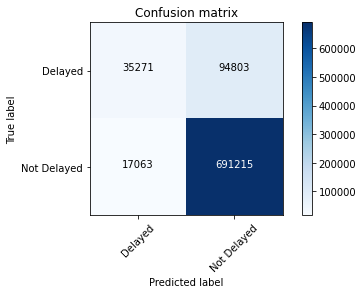

In [0]:
y_true = testSet.select("label")
y_true = y_true.toPandas()
y_true['label'] = y_true['label'].replace([0],'Not Delayed')
y_true['label'] = y_true['label'].replace([1],'Delayed')

y_pred = testSet.select("prediction")
y_pred = y_pred.toPandas()
y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [0]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# params = ParamGridBuilder()
# params = params.addGrid(lr.regParam, [.01, .1, 1, 10]) 
#                .addGrid(lr.elasticNetParam, [0, .5, 1])
# params = params.build()
# cv = CrossValidator(estimator=pipeline,
#                     estimatorParamMaps=params,
#                     evaluator=evaluator,
#                     numFolds=5)

In [0]:
# cv = cv.fit(flights_train)

## Plot ROC Curve

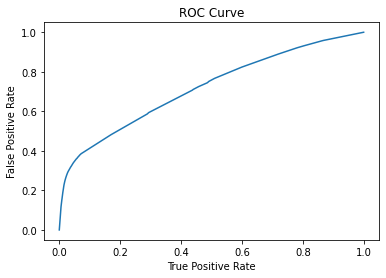

Training set areaUnderROC: 0.7170065347775996


In [0]:
trainingSummary = rf_Model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Interpreation

In [0]:
import shap

shap_values = shap.TreeExplainer(rf_Model).shap_values(train_set)
shap.summary_plot(shap_values, train_set)

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is not" with a literal. Did you mean "!="?


---------------------------------------------------------------------------
Py4JError                                 Traceback (most recent call last)
<command-2647101326227347> in <cell line: 3>()
      1 import shap
      2 
----> 3 shap_values = shap.TreeExplainer(rf_Model).shap_values(train_set)
      4 shap.summary_plot(shap_values, train_set)

/databricks/python/lib/python3.9/site-packages/shap/explainers/_tree.py in __init__(self, model, data, model_output, feature_perturbation, feature_names, approximate, **deprecated_options)
    147         self.feature_perturbation = feature_perturbation
    148         self.expected_value = None
--> 149         self.model = TreeEnsemble(model, self.data, self.data_missing, model_output)
    150         self.model_output = model_output
    151         #self.model_output = self.model.model_output # this allows the TreeEnsemble to translate model outputs types by how it loads the model

/databricks/python/lib/python3.9/site-packages/shap/expl

In [0]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import FloatType

# secondelement=udf(lambda v:float(v[1]),FloatType())
# pred2=pred.withColumn('probs',secondelement('probability'))

# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve
# import seaborn as sns

# pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()

# fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlabel('1 - Esp (FPR)')
# plt.ylabel('Sens (TPR)')
# plt.title('Curva ROC')
# plt.show()

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))

In [0]:
# # source : https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
# from pyspark.mllib.evaluation import BinaryClassificationMetrics

# class CurveMetrics(BinaryClassificationMetrics):
#     def __init__(self, *args):
#         super(CurveMetrics, self).__init__(*args)

#     def _to_list(self, rdd):
#         points = []
#         # Note this collect could be inefficient for large datasets 
#         # considering there may be one probability per datapoint (at most)
#         # The Scala version takes a numBins parameter, 
#         # but it doesn't seem possible to pass this from Python to Java
#         for row in rdd.collect():
#             # Results are returned as type scala.Tuple2, 
#             # which doesn't appear to have a py4j mapping
#             points += [(float(row._1()), float(row._2()))]
#         return points

#     def get_curve(self, method):
#         rdd = getattr(self._java_model, method)().toJavaRDD()
#         return self._to_list(rdd)
    


In [0]:
# import matplotlib.pyplot as plt

# # Create a Pipeline estimator and fit on train DF, predict on test DF
# # model = estimator.fit(train)
# # predictions = model.transform(test)

# # Returns as a list (false positive rate, true positive rate)
# preds = testSet.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
# points = CurveMetrics(preds).get_curve('roc')

# plt.figure()
# x_val = [x[0] for x in points]
# y_val = [x[1] for x in points]
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.plot(x_val, y_val)

---------------------------------------------------------------------------
Py4JError                                 Traceback (most recent call last)
<command-2647101326227133> in <cell line: 9>()
      7 # Returns as a list (false positive rate, true positive rate)
      8 preds = testSet.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
----> 9 points = CurveMetrics(preds).get_curve('roc')
     10 
     11 plt.figure()

<command-2647101326227126> in get_curve(self, method)
     19 
     20     def get_curve(self, method):
---> 21         rdd = getattr(self._java_model, method)().toJavaRDD()
     22         return self._to_list(rdd)
     23 

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1319 
   1320         answer = self.gateway_client.send_command(command)
-> 1321         return_value = get_return_value(
   1322             answer, self.gateway_client, self.target_id, self.n

In [0]:
display(train_set)

# XG BOOST

In [0]:
from sparkdl.xgboost import XgboostRegressor

xgboost = XgboostClassifier(labelCol="label", featuresCol="features", missing=0.0,  rawPredictionCol='probability',
                                #max_depth=p[0],
                                #n_estimators=p[1],
                                #reg_lambda=p[2],
                                #reg_alpha=p[3],
                                #objective=p[4],
                                #base_score = p[5],
                                #learning_rate = p[6],
                                #gamma = p[7],
                                #scale_pos_weight = p[8],
                                #min_child_weight = p[9]
                           )